In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Mean-Variance Analysis - Minimum Variance

Mean-variance analysis is a mathematical framework that examplifies the trade-off between return and risk. It is used to create diversified portfolios based on investors’ expectation. There are one main approach used in this report. We have the minimum volatility portfolio that concentrates on minimizing the risk of the portfolio. Mimimum variance portfolio can help us compare the correlation of simple sample covariance and covariance generated using cosine similarity distances.

### Monthly Returns

In [2]:
returns_data = pd.read_csv('../data/returns_2018_top5_SIC.csv', 
                      parse_dates = ['DATE'], 
                      usecols = ["trt1m", "CIK", "name", "DATE"])

In [3]:
# TAKE OUT THE DATA before 2019 and reset index
end_date = pd.to_datetime('2019-01-01')
returns = returns_data.loc[(returns_data['DATE'] < end_date)]
# drop the missing value
returns = returns.dropna()
# group the data by name and date
group_returns = returns.groupby(['name', 'DATE'])
# calculate the percentage return
group_returns_pct = group_returns.agg({"trt1m": (lambda x:  x/100)})
r_selected = group_returns_pct.unstack()
# drop the first index
r_selected.columns = r_selected.columns.droplevel(0)

In [51]:
# there are some rows containing more than one float number (array of multiple returns)
for i in range(len(r_selected)):
    if type(r_selected.iloc[i,1]) == np.ndarray:
        r_selected = r_selected.drop(index = r_selected.index[i])
# convert object to float
r_selected = r_selected.astype(float)
# drop missing values rows
r_selected = r_selected.dropna()
# get the mean of all 
mu = r_selected.mean(axis = 1)
# compute the covariance matrix 
cov = r_selected.T.cov()

### Cosine Similarity Distances

In [26]:
df = pd.read_csv('preprocessed.csv',
                 usecols = ['reportingDate', 'name', 'CIK',
                           'coDescription_stopwords', 'SIC', 'SIC_desc'])
df = df.set_index(df.name)

#### Words Count

In [41]:
from sklearn.feature_extraction.text import CountVectorizer

Vectorizer = CountVectorizer(ngram_range = (2,4), 
                             max_features = 600)

count_data = Vectorizer.fit_transform(df['coDescription_stopwords'])
wordsCount = pd.DataFrame(count_data.toarray(),columns=Vectorizer.get_feature_names())
wordsCount = wordsCount.set_index(df['name'])
wordsCount

/Users/lulu/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,ability make,accounting standard,acquire property,act act,act amended,additional information,adequately capitalized,adverse effect,adverse effect business,adverse event,...,wa million,weighted average,well capitalized,wholly owned,wholly owned subsidiary,wide range,within day,working interest,year ended,year ended december
name,,,,,,,,,,,,,,,,,,,,,
"MONGODB, INC.",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,3,0,0,5,0
SALESFORCE COM INC,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
SPLUNK INC,0,0,0,0,1,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"OKTA, INC.",0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
VEEVA SYSTEMS INC,0,12,0,1,4,1,0,7,4,0,...,18,4,0,0,0,0,1,0,102,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"AMERICAN REALTY CAPITAL NEW YORK CITY REIT, INC.",0,0,1,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,2,2
"CYCLACEL PHARMACEUTICALS, INC.",0,0,0,0,0,1,0,1,0,1,...,0,0,0,0,0,0,1,0,0,0
ZOETIS INC.,0,17,0,0,0,12,0,3,0,0,...,20,5,0,1,1,0,2,0,84,83


In [42]:
# Compute Cosine Similarity
from sklearn.metrics.pairwise import cosine_similarity
cosine_sim = pd.DataFrame(cosine_similarity(wordsCount, wordsCount))
cosine_sim = cosine_sim.set_index(df['name'])
cosine_sim.columns = df['name']
cosine_sim

name,"MONGODB, INC.",SALESFORCE COM INC,SPLUNK INC,"OKTA, INC.",VEEVA SYSTEMS INC,AUTODESK INC,"INTERNATIONAL WESTERN PETROLEUM, INC.","DAYBREAK OIL & GAS, INC.","ETERNAL SPEECH, INC.","ETERNAL SPEECH, INC.",...,OMEGA HEALTHCARE INVESTORS INC,TABLEAU SOFTWARE INC,HORIZON PHARMA PLC,MERRIMACK PHARMACEUTICALS INC,"REVEN HOUSING REIT, INC.","AMERICAN REALTY CAPITAL NEW YORK CITY REIT, INC.","CYCLACEL PHARMACEUTICALS, INC.",ZOETIS INC.,"STAG INDUSTRIAL, INC.",EQUINIX INC
name,,,,,,,,,,,,,,,,,,,,,
"MONGODB, INC.",1.000000,0.445455,0.610272,0.620961,0.500762,0.338268,0.065380,0.052345,0.000000,0.000000,...,0.050935,0.630465,0.436327,0.143385,0.066598,0.135839,0.144678,0.189609,0.178397,0.102958
SALESFORCE COM INC,0.445455,1.000000,0.635969,0.455189,0.196053,0.418546,0.043515,0.064999,0.000000,0.000000,...,0.029326,0.492079,0.300027,0.133831,0.201221,0.201230,0.145089,0.075038,0.277952,0.354856
SPLUNK INC,0.610272,0.635969,1.000000,0.665648,0.274023,0.373142,0.019112,0.073553,0.000000,0.000000,...,0.018032,0.569939,0.330028,0.116923,0.109538,0.142041,0.128467,0.136418,0.194072,0.273502
"OKTA, INC.",0.620961,0.455189,0.665648,1.000000,0.195672,0.399874,0.013240,0.093942,0.000000,0.000000,...,0.013905,0.579884,0.541775,0.163709,0.109948,0.144051,0.170361,0.111937,0.163588,0.074624
VEEVA SYSTEMS INC,0.500762,0.196053,0.274023,0.195672,1.000000,0.079927,0.074096,0.030179,0.075713,0.075713,...,0.424046,0.280852,0.153335,0.083683,0.128762,0.211695,0.060273,0.501041,0.332207,0.064207
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"AMERICAN REALTY CAPITAL NEW YORK CITY REIT, INC.",0.135839,0.201230,0.142041,0.144051,0.211695,0.106627,0.027594,0.048087,0.000000,0.000000,...,0.284525,0.114080,0.075274,0.048741,0.578793,1.000000,0.039971,0.136184,0.471651,0.042298
"CYCLACEL PHARMACEUTICALS, INC.",0.144678,0.145089,0.128467,0.170361,0.060273,0.094262,0.010770,0.025407,0.000000,0.000000,...,0.015318,0.193458,0.462759,0.683597,0.047288,0.039971,1.000000,0.035694,0.080139,0.013121
ZOETIS INC.,0.189609,0.075038,0.136418,0.111937,0.501041,0.069267,0.039015,0.022235,0.065917,0.065917,...,0.159082,0.327556,0.148224,0.051060,0.163391,0.136184,0.035694,1.000000,0.207232,0.031911


### Perform Mean-Variance Analysis

In [43]:
from pypfopt import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt import objective_functions
from pypfopt import plotting

In [55]:
# get the names of the companies in the pharmaceutical preparations industry
Pharm = df[df.SIC == 2834]
Pharm_list = Pharm.index

In [59]:
# get the companies name that match return data and business description data
SET = (set(Pharm_list) & set(r_selected.index))
LIST = [*SET, ]

set

#### Mean and Covariance for Returns in the Pharmaceutical Preparations Industry

In [61]:
mu_Pharm = mu[LIST]

In [62]:
tmp = cov[LIST].T
cov_Pharm = tmp[LIST]

#### Cosine Similarity Distances in the Pharmaceutical Preparations Industry

In [63]:
tmp = cosine_sim[LIST].drop_duplicates().T
Pharm_cos_sim = tmp[LIST].drop_duplicates()

#### Covariance for Cosine Similarity

In [64]:
cos_sim_sd = pd.DataFrame(np.sqrt(np.diag(np.diagonal(cov_Pharm))))
cos_sim_sd = cos_sim_sd.set_index(cov_Pharm.index)
cos_sim_sd.columns = cov_Pharm.index

In [125]:
cos_sim_cov = pd.DataFrame((np.dot(np.dot(cos_sim_sd, Pharm_cos_sim),cos_sim_sd)))

,0,1,2,3,4,5,6,7,8,9,...,114,115,116,117,118,119,120,121,122,123
0,0.097249,0.052057,0.076983,0.040156,0.006122,0.013362,0.018984,0.049644,0.013358,0.034783,...,0.027262,0.016041,0.039253,0.005922,0.013354,0.014822,0.071829,0.000816,0.078328,0.041084
1,0.052057,0.067765,0.052157,0.028187,0.003929,0.006854,0.013767,0.031090,0.006422,0.024699,...,0.026633,0.005111,0.023906,0.003836,0.006330,0.006298,0.042730,0.000610,0.050821,0.025454
2,0.076983,0.052157,0.142607,0.047732,0.006762,0.020002,0.026236,0.052346,0.031577,0.036792,...,0.037315,0.026761,0.035563,0.011206,0.023757,0.016410,0.081846,0.000891,0.085944,0.051374
3,0.040156,0.028187,0.047732,0.031051,0.004213,0.007041,0.013146,0.027229,0.007693,0.017149,...,0.012175,0.010597,0.017643,0.003857,0.007644,0.008104,0.040949,0.000469,0.041066,0.019837
4,0.006122,0.003929,0.006762,0.004213,0.003017,0.002784,0.003654,0.003154,0.001543,0.002168,...,0.001481,0.002073,0.002340,0.000340,0.002044,0.002058,0.008912,0.000348,0.006350,0.004203
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119,0.014822,0.006298,0.016410,0.008104,0.002058,0.004220,0.004016,0.009183,0.001830,0.005167,...,0.008434,0.011778,0.006434,0.001718,0.004097,0.019168,0.019545,0.000587,0.014631,0.007099
120,0.071829,0.042730,0.081846,0.040949,0.008912,0.014463,0.023825,0.040217,0.011992,0.027442,...,0.028361,0.026571,0.029762,0.004441,0.015149,0.019545,0.099741,0.001451,0.072289,0.040490
121,0.000816,0.000610,0.000891,0.000469,0.000348,0.000309,0.000578,0.000511,0.000554,0.000091,...,0.001149,0.000466,0.000458,0.000236,0.001525,0.000587,0.001451,0.001698,0.001154,0.001233
122,0.078328,0.050821,0.085944,0.041066,0.006350,0.011707,0.024318,0.052397,0.025921,0.033517,...,0.031348,0.017075,0.036968,0.009328,0.020147,0.014631,0.072289,0.001154,0.107863,0.045198


### Portfolio Weights on Different Extremes

#### Comparing return mean and covariance

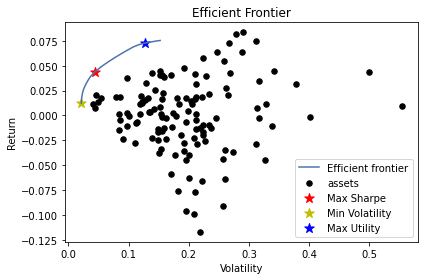

In [123]:
ef1 = EfficientFrontier(mu_Pharm, cov_Pharm, weight_bounds=(0, 0.2))

fig, ax = plt.subplots()
plotting.plot_efficient_frontier(ef1, ax=ax, show_assets=True)

# Find and plot the tangency portfolio
ef2 = EfficientFrontier(mu_Pharm, cov_Pharm, weight_bounds=(0, 0.2))
# min volatility
ef2.min_volatility()
ret_tangent, std_tangent, _ = ef2.portfolio_performance()
ax.scatter(std_tangent, ret_tangent, marker="*", s=100, c="y", label="Min Volatility")

# Format
ax.set_title("Efficient Frontier")
ax.legend()
plt.tight_layout()
plt.savefig('images/Efficient_Frontier_Returns.png', dpi=200, bbox_inches='tight')
plt.show()

##### min volatility

In [115]:
ef2.portfolio_performance(verbose=True);

Expected annual return: 1.2%
Annual volatility: 2.1%
Sharpe Ratio: -0.35


In [116]:
companies = []
weights = []
for company, weight in ef2.clean_weights().items():
    if weight != 0:
        companies.append(company)
        weights.append(weight)
        print(company, weight)

RECRO PHARMA, INC. 0.0201
ACHAOGEN INC 0.00515
ASSEMBLY BIOSCIENCES, INC. 0.05775
ZOETIS INC. 0.01195
VTV THERAPEUTICS INC. 0.02372
CYTOMX THERAPEUTICS, INC. 0.0052
ORAMED PHARMACEUTICALS INC. 0.04982
CHEMBIO DIAGNOSTICS, INC. 0.02843
BIODELIVERY SCIENCES INTERNATIONAL INC 0.0368
ARATANA THERAPEUTICS, INC. 0.03678
PFENEX INC. 0.03777
BRISTOL MYERS SQUIBB CO 0.12824
IMPRIMIS PHARMACEUTICALS, INC. 0.04181
JOHNSON & JOHNSON 0.17878
MERCK & CO., INC. 0.2
HEAT BIOLOGICS, INC. 0.00297
PROPHASE LABS, INC. 0.0512
XENON PHARMACEUTICALS INC. 0.0135
STEMLINE THERAPEUTICS INC 0.04273
LIPOCINE INC. 0.00683
MANNKIND CORP 0.02048


In [117]:
dic = {'Company_Name':companies,'Weight':weights}
min_vol = pd.DataFrame(dic)
import dataframe_image as dfi
min_vol.dfi.export('min_vol_returns.png')

[0325/061249.492149:INFO:headless_shell.cc(659)] Written to file /var/folders/6t/0lh6qmkn1zg8fhlp984cpxrr0000gn/T/tmpeahopofv/temp.png.


In [ ]:
min_vol

#### Comparing return mean and covariance from cosine similarity

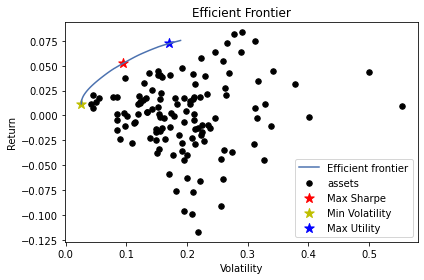

In [128]:
ef1 = EfficientFrontier(mu_Pharm, cos_sim_cov, weight_bounds=(0, 0.2))

fig, ax = plt.subplots()
plotting.plot_efficient_frontier(ef1, ax=ax, show_assets=True)

# Find and plot the tangency portfolio
ef2 = EfficientFrontier(mu_Pharm, cos_sim_cov, weight_bounds=(0, 0.2))
# max sharpe ratio
ef2.min_volatility()
ret_tangent, std_tangent, _ = ef2.portfolio_performance()
ax.scatter(std_tangent, ret_tangent, marker="*", s=100, c="r", label="Min Volatility")

# Format
ax.set_title("Efficient Frontier")
ax.legend()
plt.tight_layout()
plt.savefig('images/Efficient_Frontier_Cos_Sim.png', dpi=200, bbox_inches='tight')
plt.show()

##### Min Volatility

In [90]:
ef2.portfolio_performance(verbose=True);

Expected annual return: 5.2%
Annual volatility: 9.5%
Sharpe Ratio: 0.34


In [95]:
companies = []
weights = []
for company, weight in ef2.clean_weights().items():
    if weight != 0:
        companies.append(company)
        weights.append(weight)
        print(company, weight)

ARQULE INC 0.0007
ASSEMBLY BIOSCIENCES, INC. 0.11144
ZOETIS INC. 0.1067
PTC THERAPEUTICS, INC. 0.1202
SAREPTA THERAPEUTICS, INC. 0.06956
PROPHASE LABS, INC. 0.2
BLUEPRINT MEDICINES CORP 0.0885
CYMABAY THERAPEUTICS, INC. 0.1029
XENCOR INC 0.2


In [102]:
dic = {'Company_Name':companies,'Weight':weights}
min_vol = pd.DataFrame(dic)
min_vol.dfi.export('max_sharpe_cos_sim.png')

In [ ]:
min_vol